In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from joblib import Parallel, delayed
from scipy.optimize import minimize
import time
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import block_diag, eig

In [2]:
# if you want static figures, dont run this
%matplotlib notebook

In [3]:
# used in combination as initial conditions to find cycles
shadow_states = np.array([-1, 0, 1])

# parameters
musqr = 5
s = 2 + musqr

n = 10

all_states = np.concatenate([coord.ravel().reshape(-1, 1) for coord in np.meshgrid(*(shadow_states for i in range(n)))], axis=1)

# Single cycle equation

In [4]:
def eqn(lattice_state):
    """
    lattice_state : np.ndarray
        Vector of field values at each lattice sit
    
    """
    # the equations of motion t+1 and t-1 terms are accomplished by the "roll" function = cyclic rotation
    cost_vector = (-1 * np.roll(lattice_state, -1) + (-1*(s-2)*lattice_state**3 +
                                               s*lattice_state) - np.roll(lattice_state, 1))
    # the l2 norm, giving us a scalar cost functional
    return cost_vector

def cost(lattice_state):
    return 0.5 * np.linalg.norm(eqn(lattice_state))**2

def jac(lattice_state):
    """
    Jacobian of the COST FUNCTION
    
    """
    F = eqn(lattice_state)
    JTF = -np.roll(F, 1) - np.roll(F, -1) + (-3 * (s - 2) * lattice_state**2 + s) * F  
    return JTF

def find_cycles(n):
    """
    Returns all cycles of length n; numerical tolerance is not checked for each instance. 
    """
    # this creates all cycle combinations to use as initial conditions.
    initial_conditions = list(itertools.product(*(shadow_states for i in range(n))))
    cycles = []
    # this runs the l-bfgs-b optimization algorithm for each initial condition
    with Parallel(n_jobs=-2) as parallel:
        cycles = parallel(delayed(minimize)(cost, phi, jac=jac, method='l-bfgs-b') for phi in initial_conditions)
    
    # scipy technically returns objects which describe the run time statistics; this simply returns
    # the final lattice states (may not be fully converged).
    
    # It returns them in an array of shape [N, 2]
    solutions = np.array([sol.x for sol in cycles])
    return solutions

In [5]:
def jacmatrix(lattice_state):
    """
    Returns a jacobian matrix
    """
    n = lattice_state.size
    J = (np.diag((-3*(s-2)*lattice_state**2 + s)) +
                 np.diag(-1*np.ones(n-1), k=1) +
                 np.diag(-1*np.ones(n-1), k=-1))
    J[0, -1] = -1
    J[-1, 0] = -1
    return J

# Completely tensorized cycle equations

The cycles are independent, and so we can store them in a $3^N$ by $N$ dimensional tensor (one row for each initial condition)
and then solve all at once by reshaping into a $N * 3^N$ dimensional vector.

The jacobian of this new abstraction would be a block diagonal matrix, each block corresponding to the jacobian matrix of each cycle. 

In [6]:
def cycle_eqn(cycle_state, n):
    """
    lattice_state : np.ndarray
        State variable
    
    """
    lattice_state = cycle_state.reshape(-1, n) 
    # the equations of motion
    eqn_tensor = (-1 * np.roll(lattice_state, -1, axis=1) + (-1*(s-2)*lattice_state**3 +
                                               s*lattice_state) - np.roll(lattice_state, 1, axis=1))
    # the l2 norm, giving us a scalar cost functional
    return eqn_tensor

def cycle_cost(cycle_state, n):
    return (0.5*np.linalg.norm(cycle_eqn(cycle_state, n), axis=1)**2).sum()

def cycle_jac(lattice_state, n):
    lattice_state = lattice_state.reshape(-1, n) 
    Ftensor = cycle_eqn(lattice_state, n)
    JTF = -np.roll(Ftensor, 1, axis=1) - np.roll(Ftensor, -1, axis=1) + (-3 * (s - 2) * lattice_state**2 + s) * Ftensor  
    return JTF.ravel()

def find_cycle_tensor(n):
    # if you want to tweak various scipy parameters; this makes it slightly more accurate 
    options = {}
#     options={'ftol': 1e-6, 'gtol': 1e-10, 'maxfun': 10000,
#                      'maxiter': 10000, 'disp': 1}
    all_lattice_states = np.concatenate([coord.ravel().reshape(-1, 1) for coord in np.meshgrid(*(shadow_states
                                                                                         for i in range(n)))], axis=1)
    cycles = minimize(cycle_cost, all_lattice_states, jac=cycle_jac, args=(n,), method='l-bfgs-b', options=options)
    cycle_tensor = cycles.x.reshape(-1, n)
    return cycle_tensor

def all_n_cycle_jacobians(all_n_cycles):
    J = np.zeros([3**n, n, n])
    # we are going to do some REALLY CONFUSING index manipulation. I highly recommend not spending too much time on 
    # understanding this. It's just to fill in the correct elements of the tensor with the single cycle jacobian values.
    upper_rows, upper_cols = kth_diag_indices(J[0], -1)
    lower_rows, lower_cols = kth_diag_indices(J[0], 1)
    zeroth = np.repeat(np.arange(3**n), len(upper_rows))
    upper_rows = np.tile(upper_rows, 3**n)
    upper_cols = np.tile(upper_cols, 3**n)
    lower_rows = np.tile(lower_rows, 3**n)
    lower_cols = np.tile(lower_cols, 3**n)

    J[zeroth, upper_rows, upper_cols] = -1
    J[zeroth, lower_rows, lower_cols] = -1
    J[:, 0, -1] = -1
    J[:, -1, 0] = -1
    tensor_diagonal = (-3*(s-2)*all_n_cycles**2 + s).ravel()

    rows, cols = np.diag_indices(n)
    zeroth = np.repeat(np.arange(3**n), len(rows))

    J[zeroth, np.tile(rows, 3**n), np.tile(cols, 3**n)] = tensor_diagonal
    return J

def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols
    
def n_cycle_everything(n):
    all_n_cycles = find_cycle_tensor(n)

    n_jacobians = all_n_cycle_jacobians(all_n_cycles)

    all_eig_val = []
    all_eig_vec = []
    for each_jac in n_jacobians:
        val, vec = eig(each_jac)
        all_eig_val.append(val)
        all_eig_vec.append(vec[np.newaxis])
    all_eig_val = np.concatenate(all_eig_val)
    all_eig_vec = np.concatenate(all_eig_vec)
    return all_n_cycles, all_eig_val, all_eig_vec, n_jacobians

In [7]:
n = 7
cycles, eigen_values, eigen_vectors, jacobians = n_cycle_everything(n)

In [8]:
%%timeit
n = 7
cycles, eigen_values, eigen_vectors, jacobians = n_cycle_everything(n)

133 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
# if you wanted the block diagonal matrix of all n-cycle jacobians. Can very easily eat up all of your memory, use
# at your own risk
# val, vec = eig(block_diag(*tuple(n_jacobians)))

Eigenvalues only have real components; here they are plotted on the real line.

<IPython.core.display.Javascript object>


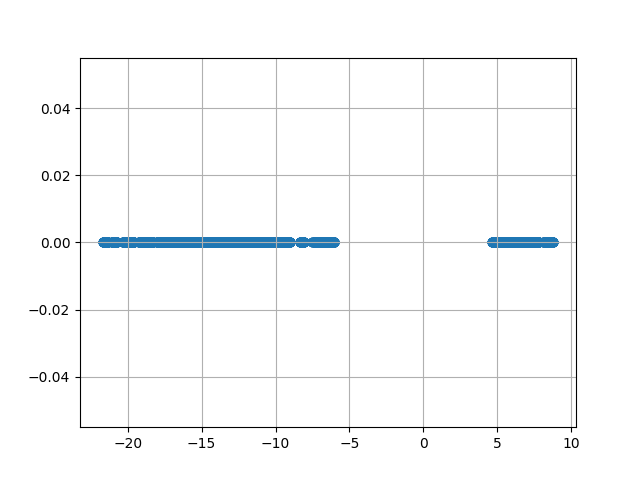

In [10]:
plt.figure()
plt.scatter(np.sort(eigen_values.real.ravel()), np.zeros(len(eigen_values)))
plt.grid()
plt.show()

As a line plot (think of this like a cumulative distribution function)

<IPython.core.display.Javascript object>


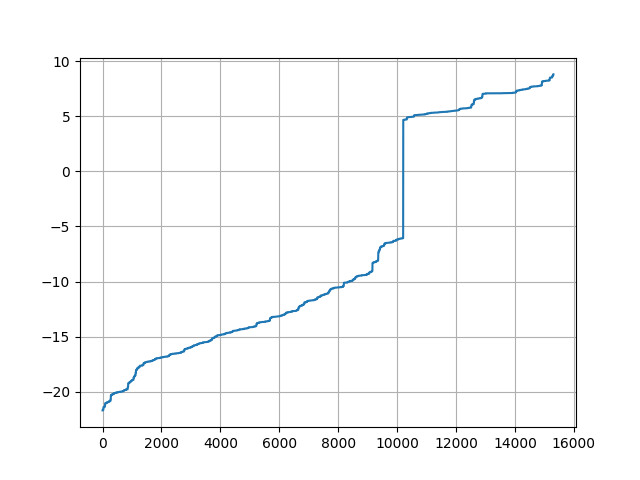

In [11]:
plt.figure()
plt.plot(np.sort(eigen_values.real.ravel()))
plt.grid()
plt.show()

As a histogram

<IPython.core.display.Javascript object>


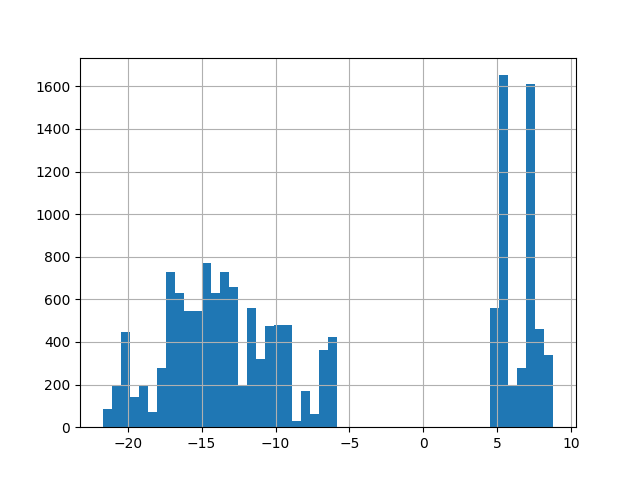

In [12]:
plt.figure()
plt.hist(eigen_values.real.ravel(), bins=50)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


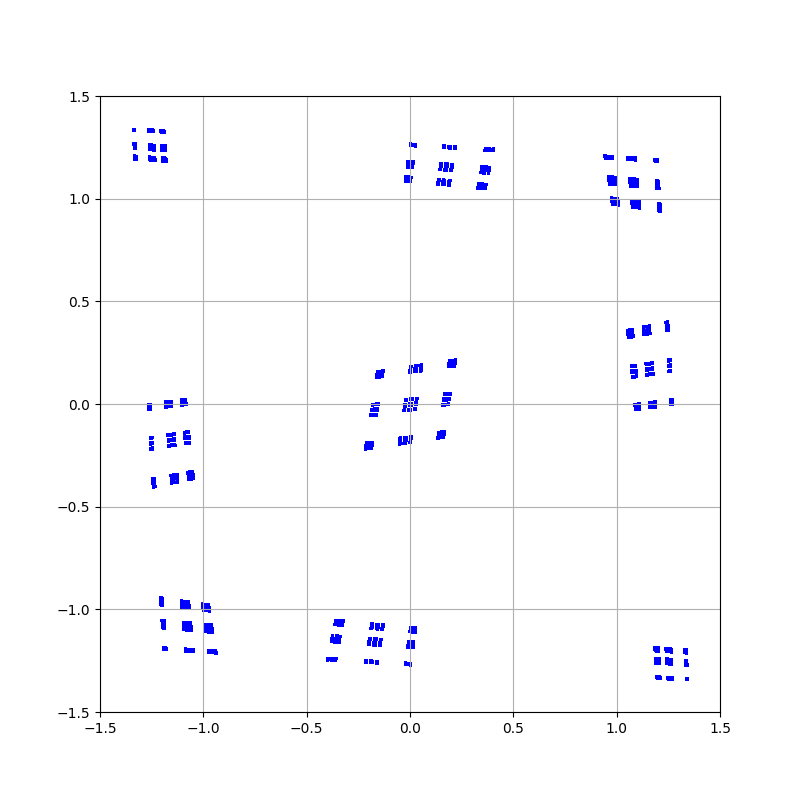

62.03550100326538


In [13]:
plt.figure(figsize=(8,8))
t0 = time.time_ns()/10**9
for i in range(2, 13):
    cycles = find_cycle_tensor(i)
    plt.scatter(cycles[:, 0], cycles[:, 1], color='b', alpha=0.5, s=0.5)
t1 = time.time_ns()/10**9
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.grid()
plt.show()
print(t1-t0)

In [ ]:
cycles = find_cycle_tensor(8)

<IPython.core.display.Javascript object>


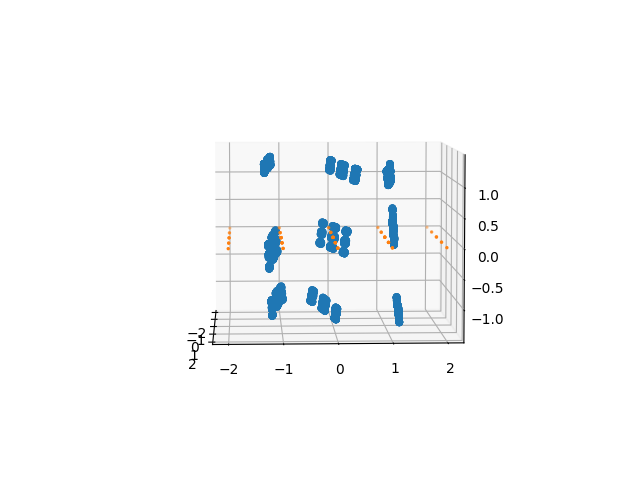

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cycles[:, 0], cycles[:, 1], cycles[:, 2])
plt.show()

In [17]:
cycles.shape

(6561, 8)

In [18]:
3**8

6561

In [25]:
itertools.combinations?

In [130]:
n=3
# this creates all cycle combinations to use as initial conditions.
initial_conditions = np.array(list(itertools.product(*(shadow_states for i in range(n)))))

In [131]:
from functools import lru_cache

In [132]:
def prime_cycles(n):
    if n == 1:
        return {-1, 0, 1}
    if n == 2:
        return prime_cycles(1)
    

In [133]:
from scipy.fft import fft

In [136]:
x, y = fft(initial_conditions, axis=1, norm='ortho')[:, 1].real, fft(initial_conditions, axis=1, norm='ortho')[:, 1].imag

idx = np.where(x != 0)
theta = np.arctan(y[idx]/x[idx])

# postheta = theta - theta.min()
prime_cycles = np.where(np.abs(theta) <= 2*np.pi/n)[0]

In [139]:
np.arctan(y[idx]/x[idx])

array([-1.04719755, -1.04719755,  1.04719755, -0.        , -0.52359878,
        1.04719755,  0.52359878, -0.        ,  0.        ,  1.04719755,
       -1.04719755, -1.04719755,  1.04719755, -0.        ,  0.        ,
        0.52359878,  1.04719755, -0.52359878,  0.        ,  1.04719755,
       -1.04719755, -1.04719755])

In [284]:
n=4
# this creates all cycle combinations to use as initial conditions.
initial_conditions = np.array(list(itertools.product(*(shadow_states for i in range(n)))))

c = fft(initial_conditions, norm='ortho')

boundary = np.arctan(np.sin(2*np.pi/n)/np.cos(2*np.pi/n)) 

theta = np.arctan(c.imag/c.real)

c2 = c[np.where((theta <= boundary) & (theta >= 0) & (c.imag >= 0) & (c.real >= 0))]

coord = np.where((theta <= boundary) & (theta >= 0) & (c.imag >= 0) & (c.real >= 0))

cols = coord[1]
fm = np.where(coord[1]==1)
fmrow = rows[fm[0]]
fmcol = cols[fm[0]]

C:\Users\gudo\AppData\Local\Temp\ipykernel_1720\3108167114.py:9: RuntimeWarning: divide by zero encountered in true_divide
  theta = np.arctan(c.imag/c.real)
C:\Users\gudo\AppData\Local\Temp\ipykernel_1720\3108167114.py:9: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arctan(c.imag/c.real)


In [285]:
c1 = c[fmrow, fmcol]

In [286]:
from collections import Counter

In [287]:
import pandas as pd

In [299]:
theta

array([[ 0.        ,         nan,         nan,         nan],
       [ 0.        ,  1.57079633,  0.        , -1.57079633],
       [ 0.        ,  1.57079633,  0.        , -1.57079633],
       [ 0.        , -0.        , -0.        ,  0.        ],
       [ 0.        , -0.78539816,         nan,  0.78539816],
       [ 0.        , -1.10714872,  0.        ,  1.10714872],
       [ 0.        , -0.        , -0.        ,  0.        ],
       [ 0.        , -0.46364761, -0.        ,  0.46364761],
       [        nan, -0.78539816,         nan,  0.78539816],
       [ 0.        , -1.57079633,  0.        ,  1.57079633],
       [ 0.        ,         nan,  0.        ,         nan],
       [ 0.        ,  1.57079633,  0.        , -1.57079633],
       [ 0.        ,  0.78539816,         nan, -0.78539816],
       [ 0.        , -0.        ,  0.        ,  0.        ],
       [        nan, -0.78539816,  0.        ,  0.78539816],
       [ 0.        ,  0.46364761, -0.        , -0.46364761],
       [        nan, -0.

In [296]:
np.where((theta <= boundary) & (theta >= 0) & (c.imag >= 0) & (c.real >= 0))

(array([ 1,  2,  3,  6,  7,  9, 11, 15, 17, 18, 19, 23, 25, 26, 27, 27, 27,
        28, 29, 30, 31, 31, 32, 33, 34, 35, 35, 36, 37, 37, 38, 39, 39, 41,
        41, 42, 43, 43, 44, 45, 46, 47, 47, 47, 48, 49, 49, 50, 51, 51, 52,
        53, 54, 54, 54, 55, 55, 56, 57, 57, 57, 58, 58, 59, 59, 59, 60, 61,
        61, 61, 62, 62, 62, 63, 63, 64, 64, 65, 65, 66, 66, 67, 67, 67, 67,
        68, 68, 69, 69, 69, 70, 70, 71, 71, 71, 72, 73, 73, 74, 74, 74, 75,
        75, 75, 76, 76, 77, 77, 77, 78, 78, 78, 79, 79, 79, 80],
       dtype=int64),
 array([1, 1, 2, 2, 2, 3, 1, 2, 0, 3, 3, 0, 0, 0, 1, 2, 3, 1, 1, 2, 1, 2,
        1, 2, 2, 0, 2, 3, 1, 3, 1, 2, 3, 0, 1, 2, 0, 2, 0, 3, 3, 0, 1, 3,
        3, 0, 3, 0, 0, 2, 0, 0, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 0, 1, 2,
        2, 0, 1, 2, 0, 1, 2, 2, 3, 1, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 0,
        2, 3, 0, 2, 0, 1, 2, 3, 0, 3, 0, 1, 3, 0, 2, 3, 0, 3, 0, 1, 3, 0,
        2, 3, 0, 2, 3, 0], dtype=int64))

In [295]:
c[(1, 27),:]

array([[-1.5-0.j ,  0. +0.5j, -0.5-0.j ,  0. -0.5j],
       [-1.5-0.j ,  0.5+0.j ,  0.5-0.j ,  0.5-0.j ]])

In [290]:
fmrow

array([ 1,  2, 11, 27, 28, 29, 31, 32, 37, 38, 41, 47, 54, 55, 56, 57, 58,
       59, 61, 62, 64, 65, 67, 68, 71, 74, 77], dtype=int64)

In [289]:
 initial_conditions[fmrow, :]

array([[-1, -1, -1,  0],
       [-1, -1, -1,  1],
       [-1,  0, -1,  1],
       [ 0, -1, -1, -1],
       [ 0, -1, -1,  0],
       [ 0, -1, -1,  1],
       [ 0, -1,  0,  0],
       [ 0, -1,  0,  1],
       [ 0,  0, -1,  0],
       [ 0,  0, -1,  1],
       [ 0,  0,  0,  1],
       [ 0,  1, -1,  1],
       [ 1, -1, -1, -1],
       [ 1, -1, -1,  0],
       [ 1, -1, -1,  1],
       [ 1, -1,  0, -1],
       [ 1, -1,  0,  0],
       [ 1, -1,  0,  1],
       [ 1, -1,  1,  0],
       [ 1, -1,  1,  1],
       [ 1,  0, -1,  0],
       [ 1,  0, -1,  1],
       [ 1,  0,  0,  0],
       [ 1,  0,  0,  1],
       [ 1,  0,  1,  1],
       [ 1,  1, -1,  1],
       [ 1,  1,  0,  1]])

<IPython.core.display.Javascript object>


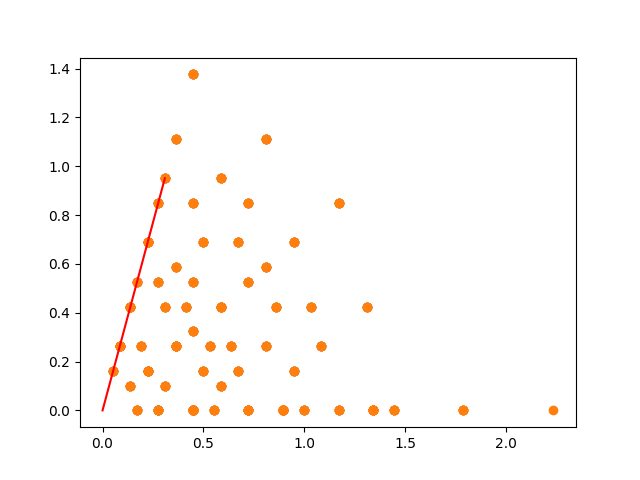

In [235]:
plt.figure()

plt.scatter(c1.real.ravel(), c1.imag.ravel())
plt.scatter(c2.real.ravel(), c2.imag.ravel())
plt.plot((0, np.cos(2*np.pi/n)), (0, np.sin(2*np.pi/n)), color='r')
plt.show()

C:\Users\gudo\AppData\Local\Temp\ipykernel_1720\1923475697.py:1: RuntimeWarning: divide by zero encountered in true_divide
  np.arctan(c.imag/c.real)
C:\Users\gudo\AppData\Local\Temp\ipykernel_1720\1923475697.py:1: RuntimeWarning: invalid value encountered in true_divide
  np.arctan(c.imag/c.real)


array([[ 0.        ,         nan,         nan,         nan,         nan],
       [ 0.        ,  1.25663706, -0.62831853,  0.62831853, -1.25663706],
       [ 0.        ,  1.25663706, -0.62831853,  0.62831853, -1.25663706],
       ...,
       [-0.        ,  1.25663706, -0.62831853,  0.62831853, -1.25663706],
       [-0.        ,  1.25663706, -0.62831853,  0.62831853, -1.25663706],
       [-0.        ,         nan,         nan,         nan,         nan]])

In [138]:
initial_conditions[prime_cycles]

array([[-1, -1, -1],
       [-1, -1,  0],
       [-1, -1,  1],
       [-1,  0, -1],
       [-1,  0,  0],
       [-1,  0,  1],
       [-1,  1, -1],
       [-1,  1,  0],
       [-1,  1,  1],
       [ 0, -1, -1],
       [ 0, -1,  0],
       [ 0, -1,  1],
       [ 0,  0, -1],
       [ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  1, -1],
       [ 0,  1,  0],
       [ 0,  1,  1],
       [ 1, -1, -1],
       [ 1, -1,  0],
       [ 1, -1,  1],
       [ 1,  0, -1]])

<IPython.core.display.Javascript object>


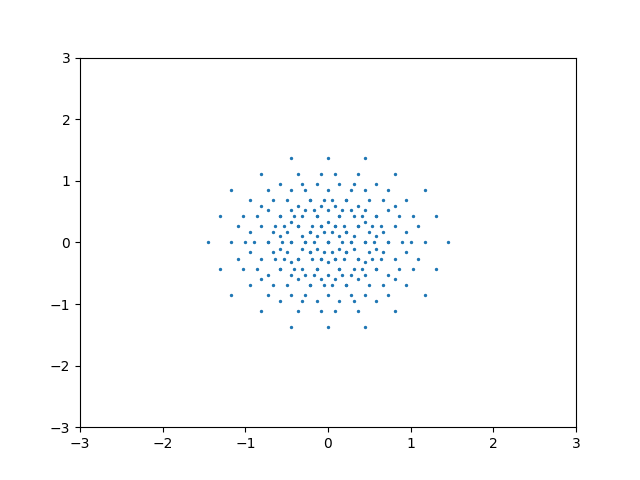

[]

In [129]:
plt.figure()
plt.scatter(x.ravel(), y.ravel(), s=2)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.plot()